In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from pprint import pprint

In [2]:
#Let's calculate power production!
import math
AM0 = 1367. # W/m^2
panel_eff = 0.29 # roughly what we usually get
area_col = (8 * 26.6 / 10000) # in m^2
ncols = 12 # assumed equally spaced

def calc_power(rads, area=area_col, p_eff=panel_eff, n=ncols):
    res = [AM0 * area * p_eff * math.cos((2 * math.pi / n) * i + rads) for i in range(n)]
    return sum([r for r in res if r >= 0])

min: 31.48, avg: 32.22, max: 32.59


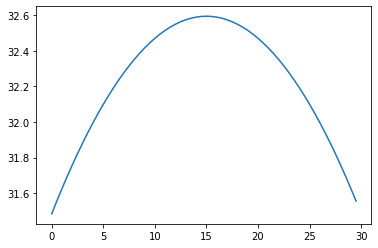

In [3]:
angles = [0.5 * i for i in range(60)]
pwrs = [calc_power(2 * math.pi * i / 360) for i in angles]
plt.plot(angles, pwrs)
print('min: {:.2f}, avg: {:.2f}, max: {:.2f}'.format(min(pwrs), sum(pwrs) / len(pwrs), max(pwrs)))

min: 160.97, avg: 161.12, max: 161.19


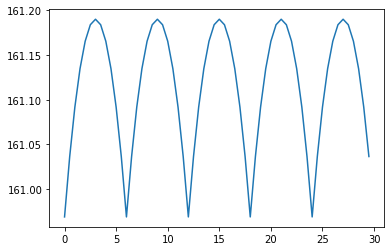

In [4]:
# neat, at a first pass we can expect to be producing 32W of power while in rotisserie/shawarma mode
# what if we got more aggressive about solar cell coverage? Double the length (along the thrust axis)
# and have a column one cell wide, every 6 degrees (my estimate is that this is packed but not overly so)
pwrs = [calc_power(2 * math.pi * i / 360, area=(26.6 * 8 / 10000), n=60) for i in angles]
plt.plot(angles, pwrs)
print('min: {:.2f}, avg: {:.2f}, max: {:.2f}'.format(min(pwrs), sum(pwrs) / len(pwrs), max(pwrs)))

In [5]:
# sanity check, what would one Dove look like? I think we were getting theoretical maxes of around 54W?
pwrs = [calc_power(2 * math.pi * i / 360, area=(26.6 * 8 * 7 / 10000), n=1) for i in angles]
print(max(pwrs))

59.0522128


In [6]:
from math import exp
# Okay, let's start creating solar-cell simulation code
# working from De Soto (2006) "Improvement and Validation of a Model for Photovoltaic Array Performance",
# we're going to create a five-parameter model. We need to encode the 5 equations and then solve them.

# Datasheet performance, as a ref using ZTJ cells from Solaero. 26.6cm^2 size.
area_cell = 26.6          # cm^2
Iscref = 17.4 * area_cell # ma
Vocref = 2.726            # V
Vmpref = 2.41             # V
Impref = 16.5 * area_cell # ma

def a(tc, ni):
    k = 1.38064852e-23    # Boltzmann's constant
    q = 1.60217662e-19    # electron charge
    return k * ni * tc / q

def equations(p):
    Il, Io, Rs, Rsh, ni = p
    tref = 298.15
    def I(i,v):
        return Il - Io * (exp((v + i * Rs) / a(tref, ni)) - 1) - (v + i*Rs) / Rsh
    ret = [I(Iscref, 0) - Iscref, I(0, Vocref), I(Impref, Vmpref) - Impref,
           Impref - Vmpref * ((-1*Io * exp((Vmpref + Impref * Rs)/a(tref, ni)) / a(tref, ni) - 1/Rsh) /
                              (1 + Io * Rs * exp((Vmpref + Impref * Rs) / a(tref, ni)) / a(tref, ni) + Rs/Rsh))]
    
    

In [7]:
from scipy.optimize import fsolve
import math

def equations(p):
    x, y = p
    return (x+y**2-4, math.exp(x) + x*y - 3)

x, y =  fsolve(equations, (1, 1))

print equations((x, y))

SyntaxError: invalid syntax (<ipython-input-7-5cc84284429e>, line 10)

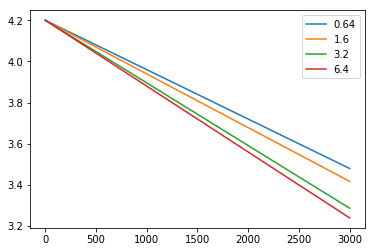

[0.20000000000000018, 0.12228260869565244, 0.08695652173913063, 0.07375]


In [15]:
# Battery analysis
def batt_linmodel(v1, cap1, v2, cap2, I, Vfull=4.2):
    m = (v2 - v1) / (cap2 - cap1)
    b = v1 - m * cap1
    Rint = (Vfull - b) / I
    Videal = lambda cap: Vfull + m * cap
    return Rint, Videal, m

lines = [(4.0, 300, 3.4, 2800, 0.64),
         (3.9, 400, 3.3, 2700, 1.6),
         (3.8, 400, 3.1, 2700, 3.2),
         (3.6, 400, 2.8, 2900, 6.4)]
rvs = [batt_linmodel(*line) for line in lines]

for rv, line in zip(rvs, lines):
    plt.plot(range(0, 3001, 100), [rv[1](c) for c in range(0, 3001, 100)], label=line[-1])
plt.legend()
plt.show()
print([rv[0] for rv in rvs])

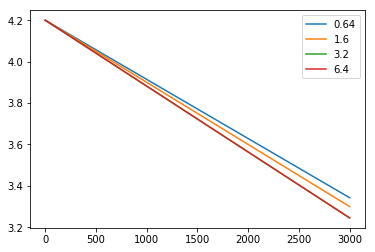

[0.17857142857142932, 0.11250000000000038, 0.08522727272727293, 0.07386363636363635]


In [14]:
lines = [(4.0, 300, 3.7, 1350, 0.64),
         (3.9, 400, 3.6, 1400, 1.6),
         (3.8, 400, 3.45, 1500, 3.2),
         (3.6, 400, 3.25, 1500, 6.4)]
rvs = [batt_linmodel(*line) for line in lines]

for rv, line in zip(rvs, lines):
    plt.plot(range(0, 3001, 100), [rv[1](c) for c in range(0, 3001, 100)], label=line[-1])
plt.legend()
plt.show()
print([rv[0] for rv in rvs])

In [16]:
batt_linmodel(*(lines[1]))

(0.12228260869565244,
 <function __main__.batt_linmodel.<locals>.<lambda>(cap)>,
 -0.00026086956521739134)